# Project 5: Flood Level Image Classification

## Executive Summary

Floods are always devasting to communites. It takes 3 to 4 days for state services to be able to deploy to those regions as they have to assess where the damage and flooding is critical. 

With our project, we aimed to be able to determime if there was indeed a flood and if so, whether it was low or high flood. This would allow state services to determine where they needed to deploy quicker as they would be using live data instead of satellite images

## Content
- [Imports](#Imports)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)

## Imports

In [1]:
# Libraries Imports

# General
import numpy as np
import pandas as pd

# Modelling
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, Conv3D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.generic_utils import get_custom_objects
def swish(x):
    return (K.sigmoid(x) * x)
get_custom_objects().update({'swish': Activation(swish)})

# Other 
import csv
import cv2
from IPython.display import display
from IPython.display import Image as _Imgdis
import os
import sys
from PIL import Image
import pickle
from time import time
from time import sleep
from tqdm import tqdm

%matplotlib inline

In [2]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0
# MIGHT NEED TO RESHAPE IT TO -3,100,100,-3!!

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
y = np.array(y)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [10]:
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [13]:
NAME = 'Flood-CNN'
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [14]:
X.shape[1:]

(100, 100, 3)

## Modelling

### CNN Model 1

In [20]:
cnn_model = Sequential()

#cnn_model.add(Flatten(input_shape = X.shape[1:]))

#Add a convolutional layer.
# Kernel size is the size of the window

cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape = X.shape[1:],padding = 'same')  # number of filters
                # height/width of filter
                # activation function 
              ) # shape of input (image)

cnn_model.add(MaxPooling2D(pool_size = (2,2))) # dimensions of region of pooling


cnn_model.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     padding = 'same',
                     activation= 'relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,3)))

cnn_model.add(Conv2D(filters = 128,
                     kernel_size=(3,3),
                     padding = 'same',
                     activation= 'relu'))
cnn_model.add(MaxPooling2D(pool_size=(3,3)))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation = 'relu'))

# Add a densely-connected layer with 64 neurons.
cnn_model.add(Dense(64, activation = 'relu'))

# Add a final layer with 3 neurons.
cnn_model.add(Dense(3, activation = 'softmax'))

In [21]:
cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 3200)             

In [22]:
# Compile model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [23]:
# Fit model on training data
history_cnn = cnn_model.fit(X_train,
                        y_train,
                        batch_size=128,
                        validation_data=(X_test, y_test),
                        epochs=30,
                        verbose=1,
                        callbacks = [tensorboard]
                           )

Epoch 1/10
17/17 [==============================] - 11s 675ms/step - loss: 1.0857 - accuracy: 0.3815 - val_loss: 1.0262 - val_accuracy: 0.4858
Epoch 2/10
17/17 [==============================] - 11s 672ms/step - loss: 1.0033 - accuracy: 0.4879 - val_loss: 0.9629 - val_accuracy: 0.5228
Epoch 3/10
17/17 [==============================] - 12s 697ms/step - loss: 0.9483 - accuracy: 0.5387 - val_loss: 0.9236 - val_accuracy: 0.5470
Epoch 4/10
17/17 [==============================] - 12s 687ms/step - loss: 0.9015 - accuracy: 0.5767 - val_loss: 0.8802 - val_accuracy: 0.5812
Epoch 5/10
17/17 [==============================] - 13s 747ms/step - loss: 0.8975 - accuracy: 0.5805 - val_loss: 0.9289 - val_accuracy: 0.5470
Epoch 6/10
17/17 [==============================] - 12s 694ms/step - loss: 0.8734 - accuracy: 0.5881 - val_loss: 0.8612 - val_accuracy: 0.6054
Epoch 7/10
17/17 [==============================] - 12s 696ms/step - loss: 0.8367 - accuracy: 0.6114 - val_loss: 0.8959 - val_accuracy: 0.5755

### CNN Model 1 with Swish Activation

In [79]:
cnn_model_swish = Sequential()

#cnn_model.add(Flatten(input_shape = X.shape[1:]))

#Add a convolutional layer.
# Kernel size is the size of the window

cnn_model_swish.add(Conv2D(filters = 32, kernel_size = (3,3), activation='swish', input_shape = X.shape[1:],padding = 'same')  # number of filters
                # height/width of filter
                # activation function 
              ) # shape of input (image)

cnn_model_swish.add(MaxPooling2D(pool_size = (2,2))) # dimensions of region of pooling


cnn_model_swish.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     padding = 'same',
                     activation= 'swish'))
cnn_model_swish.add(MaxPooling2D(pool_size=(3,3)))


cnn_model_swish.add(Conv2D(filters = 128,
                     kernel_size=(3,3),
                     padding = 'same',
                     activation= 'swish'))
cnn_model_swish.add(MaxPooling2D(pool_size=(3,3)))

cnn_model_swish.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model_swish.add(Dense(128, activation = 'swish'))

# Add a densely-connected layer with 64 neurons.
cnn_model_swish.add(Dense(64, activation = 'swish'))

# Add a densely-connected layer with 64 neurons.
cnn_model_swish.add(Dense(16, activation = 'swish'))

# Add a final layer with 3 neurons.
cnn_model_swish.add(Dense(3, activation = 'softmax'))

# Compile model
cnn_model_swish.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

cnn_swish_checkpoint_filepath = 'Checkpoints/CNN_Swish'
cnn_swish_earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='max')
cnn_swish_mcp_save = ModelCheckpoint(filepath = cnn_swish_checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', save_weights_only = True )
cnn_swish_reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')



# Fit model on training data
history_cnn_swish = cnn_model_swish.fit(X_train,
                        y_train,
                        batch_size=128,
                        validation_data=(X_test, y_test),
                        epochs=25,
                        verbose=1,
                        callbacks = [cnn_swish_earlyStopping, cnn_swish_mcp_save, cnn_swish_reduce_lr_loss]
                           )

Epoch 1/12
17/17 [==============================] - 20s 1s/step - loss: 1.0676 - accuracy: 0.4276 - val_loss: 1.0054 - val_accuracy: 0.4601 - lr: 0.0010
Epoch 2/12
17/17 [==============================] - 19s 1s/step - loss: 0.9947 - accuracy: 0.4922 - val_loss: 0.9702 - val_accuracy: 0.5028 - lr: 0.0010
Epoch 3/12
17/17 [==============================] - 20s 1s/step - loss: 0.9389 - accuracy: 0.5268 - val_loss: 0.9389 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 4/12
17/17 [==============================] - 21s 1s/step - loss: 0.9157 - accuracy: 0.5639 - val_loss: 0.9519 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 5/12
17/17 [==============================] - 20s 1s/step - loss: 0.8823 - accuracy: 0.6033 - val_loss: 0.9359 - val_accuracy: 0.5313 - lr: 0.0010
Epoch 6/12
17/17 [==============================] - 19s 1s/step - loss: 0.8517 - accuracy: 0.6076 - val_loss: 0.9011 - val_accuracy: 0.5755 - lr: 0.0010
Epoch 7/12
17/17 [==============================] - 19s 1s/step - loss: 0.8253 - a

### CNN Model 2

In [21]:
cnn_model2 = Sequential()

#Add a convolutional layer.
# Kernel size is the size of the window

cnn_model2.add(Conv2D(filters = 64, kernel_size = (3,3), activation='relu', input_shape = X.shape[1:],padding = 'same')  # number of filters
                # height/width of filter
                # activation function 
              ) # shape of input (image)

cnn_model2.add(MaxPooling2D(pool_size = (2,2))) # dimensions of region of pooling


cnn_model2.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     #padding = 'same',
                     activation= 'relu'))
cnn_model2.add(MaxPooling2D(pool_size=(3,3)))


cnn_model2.add(Conv2D(filters = 128,
                     kernel_size=(3,3),
                     padding = 'same',
                     activation= 'relu'))
cnn_model2.add(MaxPooling2D(pool_size=(4,4)))

cnn_model2.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model2.add(Dense(128, activation = 'relu'))
cnn_model2.add(Dropout(0.1))

# Add a densely-connected layer with 64 neurons.
cnn_model2.add(Dense(64, activation = 'relu'))
cnn_model2.add(Dropout(0.1))

# Add a densely-connected layer with 64 neurons.
cnn_model2.add(Dense(32, activation = 'relu'))
cnn_model2.add(Dropout(0.1))

# Add a final layer with 3 neurons.
cnn_model2.add(Dense(3, activation = 'softmax'))


# Compile model
cnn_model2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

cnn_2_checkpoint_filepath = 'Checkpoints/CNN_2'
cnn_2_earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='max')
cnn_2_mcp_save = ModelCheckpoint(filepath = cnn_2_checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', save_weights_only = True )
cnn_2_reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')


# Fit model on training data
history_cnn2 = cnn_model2.fit(X_train,
                        y_train,
                        batch_size=128,
                        validation_data=(X_test, y_test),
                        epochs=25,
                        verbose=1,
                        callbacks = [cnn_2_earlyStopping, cnn_2_mcp_save, cnn_2_reduce_lr_loss]
                           )


Epoch 1/15
17/17 [==============================] - 20s 1s/step - loss: 1.0944 - accuracy: 0.3701 - val_loss: 1.0805 - val_accuracy: 0.3618 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - 24s 1s/step - loss: 1.0765 - accuracy: 0.3895 - val_loss: 1.0399 - val_accuracy: 0.5157 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - 21s 1s/step - loss: 1.0344 - accuracy: 0.4879 - val_loss: 1.0395 - val_accuracy: 0.4630 - lr: 0.0010
Epoch 4/15
17/17 [==============================] - 22s 1s/step - loss: 1.0135 - accuracy: 0.4893 - val_loss: 0.9677 - val_accuracy: 0.5313 - lr: 0.0010
Epoch 5/15
17/17 [==============================] - 20s 1s/step - loss: 0.9851 - accuracy: 0.5259 - val_loss: 0.9361 - val_accuracy: 0.5427 - lr: 0.0010
Epoch 6/15
17/17 [==============================] - 19s 1s/step - loss: 0.9384 - accuracy: 0.5397 - val_loss: 0.8989 - val_accuracy: 0.5712 - lr: 0.0010
Epoch 7/15
17/17 [==============================] - 19s 1s/step - loss: 0.9053 - a

### CNN Model 3

In [124]:
model_3 = Sequential()

#cnn_model.add(Flatten(input_shape = X.shape[1:]))

#Add a convolutional layer.
# Kernel size is the size of the window

model_3.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', input_shape = X.shape[1:],padding = 'same')  # number of filters
                # height/width of filter
                # activation function 
              ) # shape of input (image)

model_3.add(MaxPooling2D(pool_size = (2,2))) # dimensions of region of pooling


model_3.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     #padding = 'same',
                     activation= 'relu'))
model_3.add(MaxPooling2D(pool_size=(3,3)))

model_3.add(Conv2D(filters = 64,
                     kernel_size=(3,3),
                     padding = 'same',
                     activation= 'relu'))
model_3.add(MaxPooling2D(pool_size=(4,4)))

model_3.add(Flatten())

# Add a densely-connected layer with 128 neurons.
model_3.add(Dense(256, activation = 'relu'))
model_3.add(Dropout(0.1))

# Add a densely-connected layer with 64 neurons.
model_3.add(Dense(128, activation = 'relu'))
model_3.add(Dropout(0.1))

# Add a densely-connected layer with 64 neurons.
model_3.add(Dense(64, activation = 'relu'))
model_3.add(Dropout(0.1))

# Add a densely-connected layer with 64 neurons.
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dropout(0.1))


# Add a final layer with 3 neurons.
model_3.add(Dense(3, activation = 'softmax'))


# Compile model
model_3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model_3_checkpoint_filepath = 'Checkpoints/Model_3'
model_3_earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='max')
model_3_mcp_save = ModelCheckpoint(filepath = model_3_checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max', save_weights_only = True )
model_3_reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')


# Fit model on training data
history_model_3 = model_3.fit(X_train,
                        y_train,
                        batch_size=128,
                        validation_data=(X_test, y_test),
                        epochs=25,
                        verbose=1,
                        callbacks = [model_3_earlyStopping, model_3_mcp_save, model_3_reduce_lr_loss]
                           )



Epoch 1/25
17/17 [==============================] - 12s 679ms/step - loss: 1.0900 - accuracy: 0.3667 - val_loss: 1.0738 - val_accuracy: 0.4188 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - 12s 702ms/step - loss: 1.0521 - accuracy: 0.4100 - val_loss: 0.9778 - val_accuracy: 0.4986 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - 12s 689ms/step - loss: 0.9917 - accuracy: 0.4817 - val_loss: 1.0186 - val_accuracy: 0.4245 - lr: 0.0010
Epoch 4/25
17/17 [==============================] - 12s 690ms/step - loss: 0.9753 - accuracy: 0.5026 - val_loss: 0.9147 - val_accuracy: 0.5370 - lr: 0.0010
Epoch 5/25
17/17 [==============================] - 12s 706ms/step - loss: 0.9375 - accuracy: 0.5292 - val_loss: 0.8970 - val_accuracy: 0.5527 - lr: 0.0010
Epoch 6/25
17/17 [==============================] - 12s 711ms/step - loss: 0.9136 - accuracy: 0.5430 - val_loss: 0.8825 - val_accuracy: 0.5670 - lr: 0.0010
Epoch 7/25
17/17 [==============================] - 12s 701ms/st

## Model Evaluation

In [27]:
rounded_labels=np.argmax(y_test, axis=1)
rounded_labels[1]

1

### CNN Model 1 - Model Evaluation

In [130]:
predict_model_cnn = cnn_model.predict_classes(X_test, batch_size=128, verbose=0)
cm_model_cnn = metrics.confusion_matrix(rounded_labels, predict_model_cnn)
#Confusion Matrix
cm_model_cnn_df = pd.DataFrame(cm_model_cnn, columns = ['predicted_High_Flood','predicted_Low_Flood', 'predicted_No_Flood'], 
                     index = ['actual_High_Flood', 'actual_Low_Flood', 'actual_No_Flood'])
cm_model_cnn_df

,predicted_High_Flood,predicted_Low_Flood,predicted_No_Flood
actual_High_Flood,188,46,25
actual_Low_Flood,101,68,20
actual_No_Flood,39,43,172


### CNN Model 2 - Model Evaluation

In [28]:
predict_model_cnn2 = cnn_model2.predict_classes(X_test, batch_size=128, verbose=0)
cm_model_cnn2 = metrics.confusion_matrix(rounded_labels, predict_model_cnn2)
#Confusion Matrix
cm_model_cnn2_df = pd.DataFrame(cm_model_cnn2, columns = ['Predicted High Flood','Predicted Low Flood', 'Predicted No Flood'], 
                     index = ['Actual High Flood', 'Actual Low Flood', 'Actual No Flood'])
cm_model_cnn2_df

,Predicted High Flood,Predicted Low Flood,Predicted No Flood
Actual High Flood,158,46,55
Actual Low Flood,62,86,41
Actual No Flood,25,24,205


| Actual vs Predicted|Predicted High Flood|Predicted Low Flood|Predicted No Flood|
|---|---|---|---|
|Actual High Flood|158|46|55| 
|Actual Low Flood|62|86|41| 
|Actual No Flood |25|24|205| 

In [29]:
missclassified_cnn_2 = pd.DataFrame(y_test)

In [30]:
missclassified_cnn_2.loc[missclassified_cnn_2[0] == 1, 'actual'] = 0
missclassified_cnn_2.loc[missclassified_cnn_2[1] == 1, 'actual'] = 1
missclassified_cnn_2.loc[missclassified_cnn_2[2] == 1, 'actual'] = 2
missclassified_cnn_2['actual'] = missclassified_cnn_2['actual'].astype(int)


In [32]:
missclassified_cnn_2['predicted'] = (pd.DataFrame(predict_model_cnn2)[0])

In [33]:
missclassified_cnn_2 = missclassified_cnn_2[['actual','predicted']]
missclassified_cnn_2['missclassified'] = missclassified_cnn_2['actual'] != missclassified_cnn_2['predicted']

In [1]:
missclassified_cnn_2[missclassified_cnn_2['missclassified'] == True].head()

NameError: name 'missclassified_cnn_2' is not defined

#### Examples of missclassified images

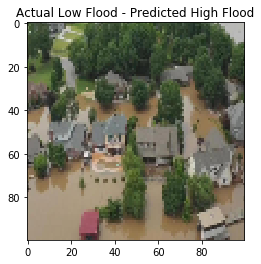

In [287]:
plt.imshow(X_test[689][...,::-1])
plt.title('Actual Low Flood - Predicted High Flood')
plt.show()

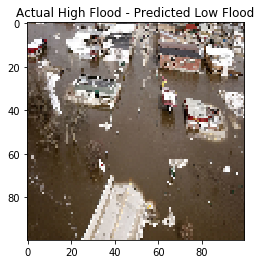

In [284]:
plt.imshow(X_test[694][...,::-1])
plt.title('Actual High Flood - Predicted Low Flood')
plt.show()

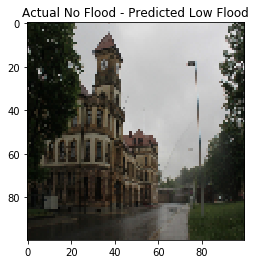

In [99]:
plt.imshow(X_test[692][...,::-1])
plt.title('Actual No Flood - Predicted Low Flood')
plt.show()

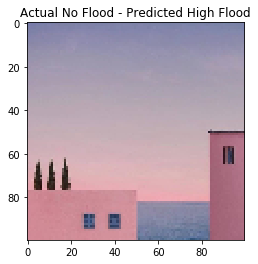

In [81]:
plt.imshow(X_test[45][...,::-1])
plt.title('Actual No Flood - Predicted High Flood')
plt.show()

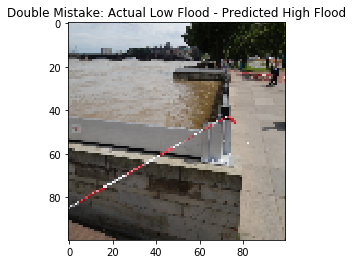

In [295]:
plt.imshow(X_test[698][...,::-1])
plt.title('Double Mistake: Actual Low Flood - Predicted High Flood')
plt.show()

### Displaying Curves of loss and accuracy 

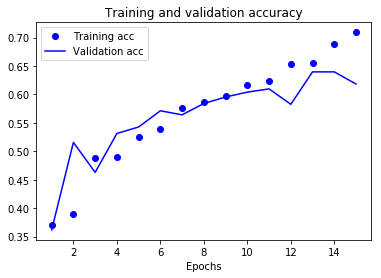

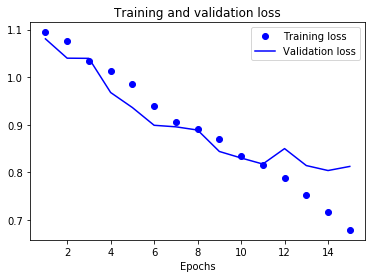

In [98]:

acc = history_cnn2.history['accuracy']
val_acc = history_cnn2.history['val_accuracy']
loss = history_cnn2.history['loss']
val_loss = history_cnn2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

### CNN Model 3 - Model Evaluation

In [127]:
#Confusion Matrix
predict_model_3 = model_3.predict_classes(X_test, batch_size=128, verbose=0)
cm_model_3 = metrics.confusion_matrix(rounded_labels, predict_model_3)
cm_model_3_df = pd.DataFrame(cm_model_3, columns = ['predicted_High_Flood','predicted_Low_Flood', 'predicted_No_Flood'], 
                     index = ['actual_High_Flood', 'actual_Low_Flood', 'actual_No_Flood'])
cm_model_3_df

,predicted_High_Flood,predicted_Low_Flood,predicted_No_Flood
actual_High_Flood,147,47,65
actual_Low_Flood,55,83,51
actual_No_Flood,19,26,209


In [297]:
missclassified_model_3 = pd.DataFrame(y_test)
missclassified_model_3.loc[missclassified_model_3[0] == 1, 'actual'] = 0
missclassified_model_3.loc[missclassified_model_3[1] == 1, 'actual'] = 1
missclassified_model_3.loc[missclassified_model_3[2] == 1, 'actual'] = 2
missclassified_model_3['actual'] = missclassified_model_3['actual'].astype(int)

In [298]:
missclassified_model_3['predicted'] = (pd.DataFrame(predict_model_3)[0])
missclassified_model_3 = missclassified_model_3[['actual','predicted']]
missclassified_model_3['missclassified'] = missclassified_model_3['actual'] != missclassified_model_3['predicted']


In [2]:
missclassified_model_3[missclassified_model_3['missclassified'] == True].tail()

NameError: name 'missclassified_model_3' is not defined

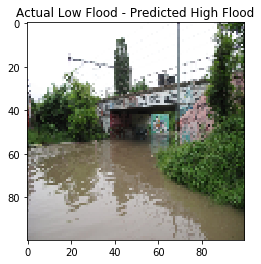

In [303]:
### Examples of Missclassified Images

plt.imshow(X_test[682][...,::-1])
plt.title('Actual High Flood - Predicted Low Flood')
plt.show()